In [2]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import sys
import matplotlib.pyplot as plt
from master_data_functions.functions import *
from master_models.pretrained import pretrained_model
import lime
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:

# File import
# Sample filenames are:
# CeBr10kSingle_1.txt -> single events, 
# CeBr10kSingle_2.txt -> single events
# CeBr10k_1.txt -> mixed single and double events 
# CeBr10.txt -> small file of 10 samples
# CeBr2Mil_Mix.txt -> 2 million mixed samples of simulated events

# Flag import, since we can now import 200k events from .npy files
from_file = False
if from_file:

    folder = "simulated"
    filename = "CeBr2Mil_Mix.txt"
    num_samples = 2e5
    #folder = "sample"
    #filename = "CeBr10k_1.txt"
    #num_samples = 1e3

    data = import_data(folder=folder, filename=filename, num_samples=num_samples)
    images = data[filename]["images"]
    energies = data[filename]["energies"]
    positions = data[filename]["positions"]
    labels = to_categorical(data[filename]["labels"])
    n_classes = labels.shape[1]
else:
    images = load_feature_representation("images_noscale_200k.npy")
    energies = load_feature_representation("energies_noscale_200k.npy")
    positions = load_feature_representation("positions_noscale_200k.npy")
    labels = load_feature_representation("labels_noscale_200k.npy")

n_classes = labels.shape[1]
print("Number of classes: {}".format(n_classes))
print("Images shape: {}".format(images.shape))
print("Energies shape: {}".format(energies.shape))
print("Positions shape: {}".format(positions.shape))
print("Labels shape: {}".format(labels.shape))


Number of classes: 2
Images shape: (200000, 16, 16, 1)
Energies shape: (200000, 2)
Positions shape: (200000, 4)
Labels shape: (200000, 2)


In [8]:
MODEL_PATH = "../../data/output/models/"
FIGURE_PATH = "../../"
#name = "Project-0.97.hdf5"
#name = "DenseNet201-0.92.hdf5"
name = "VGG16-0.86.hdf5"

#loaded_model = tf.keras.models.load_model(MODEL_PATH+name)
loaded_model = pretrained_model()

# Load model
net = "Project"

# Indices to use for training and test
x_idx = np.arange(images.shape[0])

# Split the indices into training and test sets
train_idx, test_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.2)    

test_positions = positions[test_idx]
train_positions = positions[train_idx]
test_energies = energies[test_idx]
train_energies = energies[train_idx]
x_train = np.concatenate((images[train_idx], images[train_idx], images[train_idx]), axis=-1)
x_test = np.concatenate((images[test_idx], images[test_idx], images[test_idx]), axis=-1)
y_test = labels[test_idx]
y_train = labels[train_idx]


y_true = y_test.argmax(axis=-1)
tmp_predicted = loaded_model.predict(x_test[20:21])
y_pred = tmp_predicted.argmax(axis=-1)

# indices, relative distances and relative energies for test set
single_indices, double_indices, close_indices = event_indices(test_positions)
rel_distance_test = relative_distance(test_positions)
energy_diff_test = energy_difference(test_energies)
rel_energy_test = relative_energy(test_energies)


ValueError met, breaking the layer addition loop


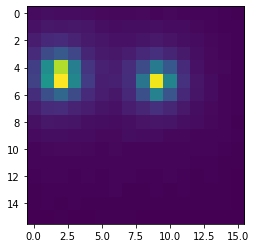

In [25]:
plt.imshow(images[test_idx][25001].reshape((16,16)))

In [26]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(x_test[25001], loaded_model.predict, hide_color=0, num_samples=1000)

100% |########################################################################|


W0213 19:22:00.568319 139637692970816 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


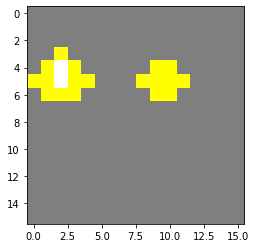

In [35]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))